In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip /content/drive/MyDrive/final_dataset_teacher.zip

In [3]:
# Importing libraries and modules
import numpy as np
import pandas as pd
import scipy
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cut_tree, set_link_color_palette, dendrogram
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading, SelfTrainingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [4]:
# Reading the first dataset and dropping irrelevant columns
df = pd.read_csv("final_complete_teacher_dataset.csv")
df1 = df.drop(df.columns[[0, 1, 2, 13]], axis=1)

X1 = df1.iloc[:, :-1].values
y1 = df.iloc[:, -1].values

In [5]:
# Reading the second dataset and dropping irrelevant columns
d = pd.read_csv("final_dataset_teacher.csv")
df = d.drop(d.columns[[0, 1, 12]], axis=1)

X = df[['q1', 'q2', 'q3', 'q4', 'q5', 'q6', 'q7', 'q8', 'q9', 'q10']].to_numpy()
y = df.iloc[:, -1].values

In [23]:
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.6, stratify=y)

In [24]:
# Creating the SVM classifier
clf = SVC(kernel='linear', C=100)

In [ ]:
self_model = SelfTrainingClassifier(clf)
self_model.fit(X_labeled, y_labeled)

In [26]:
# Predict categories for all teachers
predicted_categories = self_model.predict(X)
predicted_cats = self_model.predict(X1)

In [ ]:
# Fitting the SVM model to the entire second dataset only on the first two features
self_model.fit(X[:,:2], y)

In [28]:
# Defining the maximum and minimum values of the first two features
x_min, x_max = X[:, 0]. min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 0]. min() - 1, X[:, 1].max() + 1

# Creating a meshgrid spanning the range of training data
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

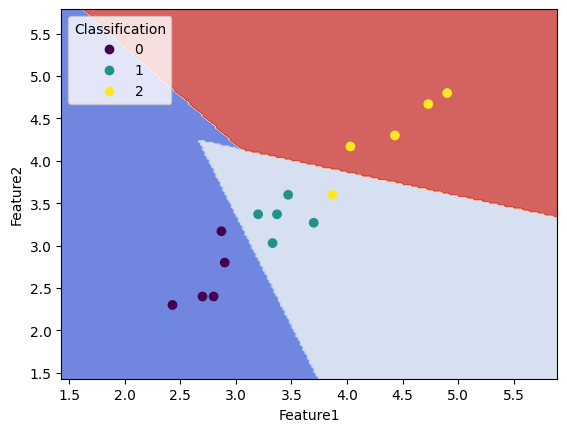

In [29]:
# Predicting the label for each point in the meshgrid
Z = self_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting decision boundary as a contour plot
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plotting the training data as scatter points
scat=plt.scatter(X[:, 0], X[:, 1], c=predicted_categories)
legend1=plt.legend(*scat.legend_elements(),
                   loc="upper left", title="Classification")

plt.xlabel('Feature1')
plt.ylabel('Feature2')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# Displaying the plot
plt.show()

In [30]:
# Calculate F1-score
f1 = f1_score(y1, predicted_cats, average='weighted')

In [31]:
print(f"F1-score: {f1}")

F1-score: 0.947223523985926
